# Information Diffusion in GNNs: Graph Classification Application

In this notebook, we'll explore how Graph Neural Networks can be used for graph classification tasks. Unlike node classification where we predict properties of individual nodes, graph classification involves predicting a label for an entire graph. This is essential for applications like molecule property prediction, protein function classification, and social network analysis.

## 1. Introduction to Graph Classification

Graph classification is a fundamental task in graph learning where the goal is to assign a label to an entire graph rather than to individual nodes. Some key applications include:

- **Molecular property prediction**: Predicting whether a molecule (represented as a graph) has certain properties like solubility or toxicity
- **Protein function classification**: Identifying the function of a protein based on its structure
- **Social network classification**: Categorizing communities or groups in social networks
- **Document classification**: Classifying documents represented as graphs of words or concepts

GNNs are well-suited for graph classification because they can:
1. Learn node-level representations through information diffusion
2. Aggregate these representations to obtain a graph-level embedding
3. Use this embedding to make predictions about the entire graph

## 2. Working with the MUTAG Dataset

For this demonstration, we'll use the MUTAG dataset, which consists of 188 chemical compounds labeled according to their mutagenic effect on a bacterium. Each graph represents a molecule, with nodes representing atoms and edges representing bonds.

Processing...
Done!


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


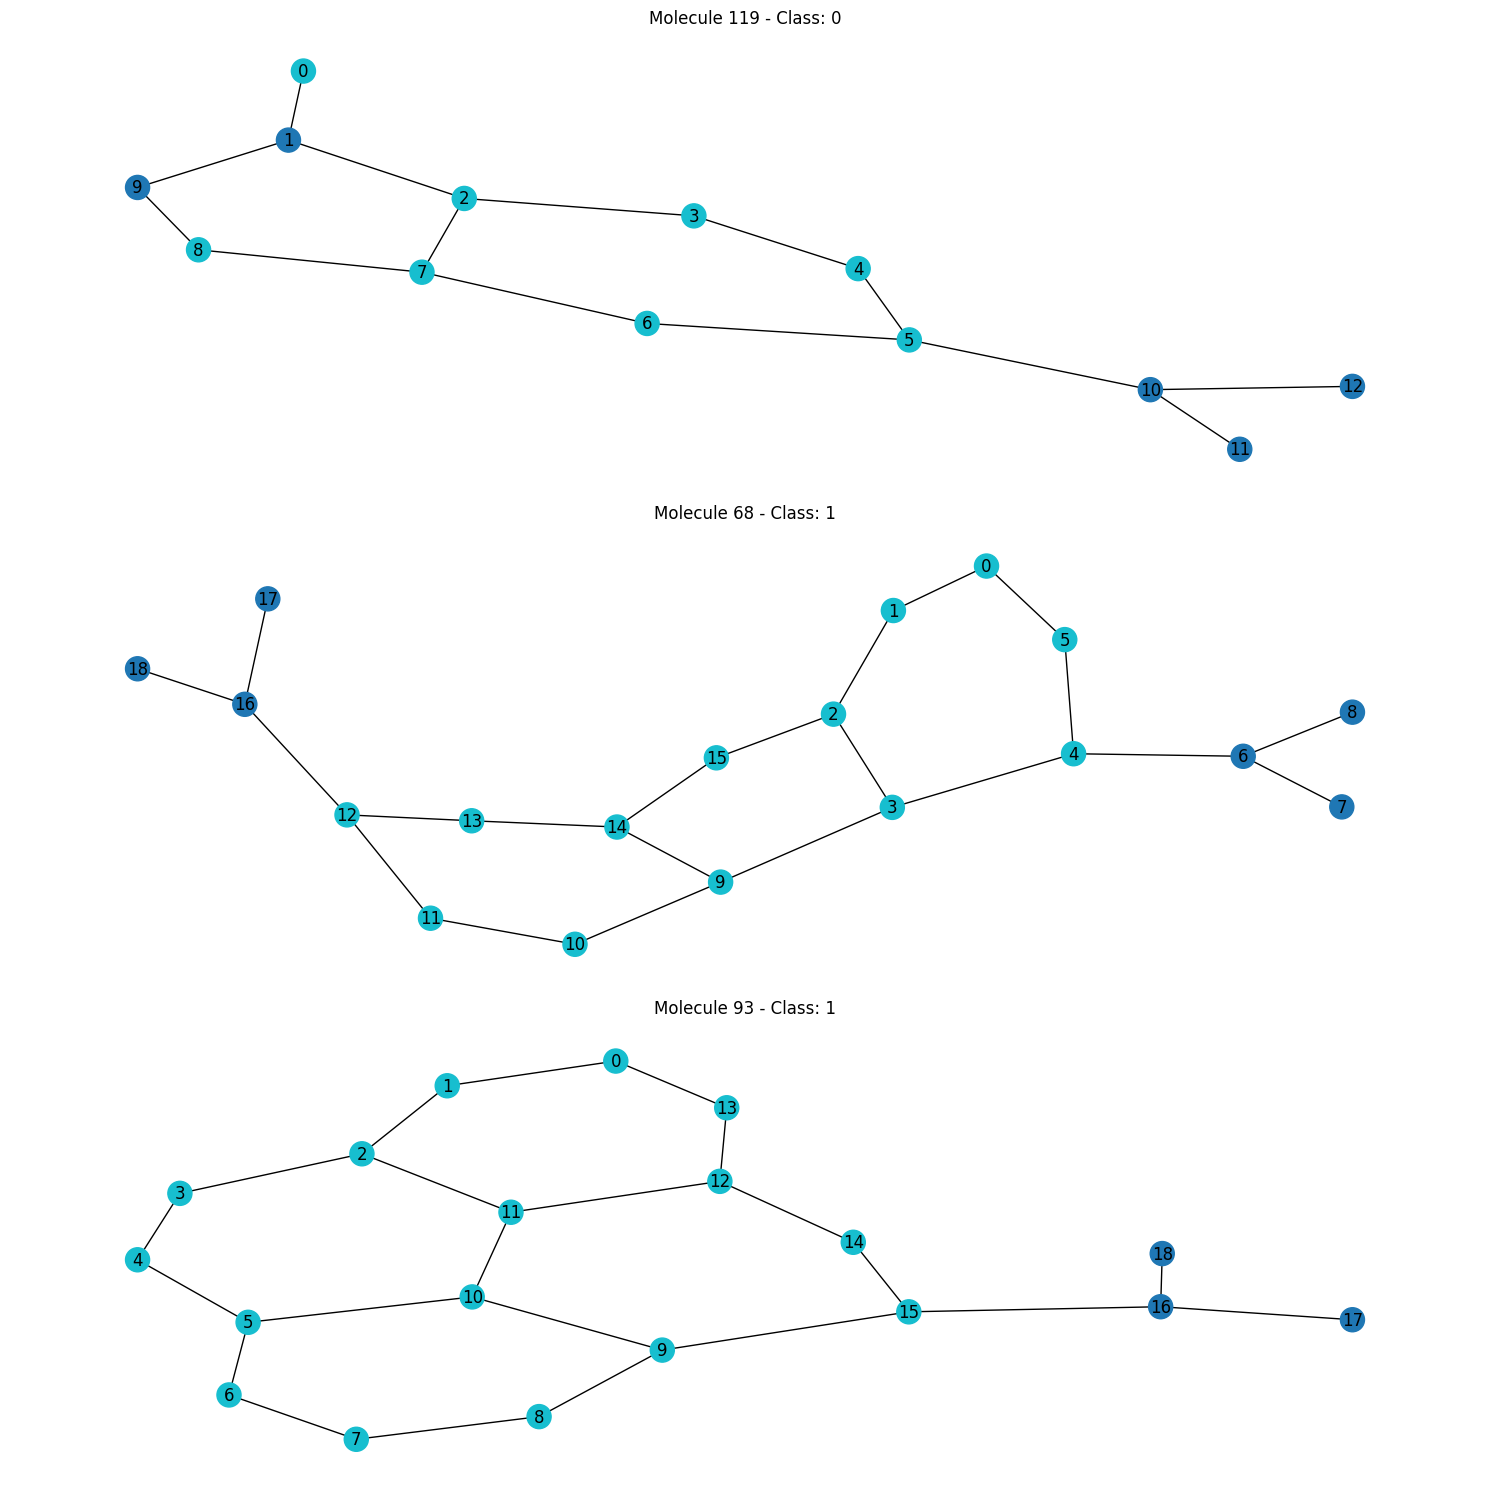

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm

# We'll use PyTorch Geometric for this task, as it provides convenient utilities for graph datasets
#!pip install -q torch-geometric
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

# Load the MUTAG dataset
def load_mutag_dataset():
    """
    Load the MUTAG dataset and prepare it for graph classification.
    
    Returns:
        dataset: PyTorch Geometric dataset
        dataloaders: Dictionary of train/val/test dataloaders
    """
    # Download and load the dataset
    dataset = TUDataset(root='data/MUTAG', name='MUTAG')
    
    # Print dataset statistics
    print(f"Dataset: {dataset}:")
    print(f"Number of graphs: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")
    
    # Split dataset into train, validation, and test sets
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
    train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.15, random_state=42)
    
    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    
    return dataset, dataloaders

# Load the dataset
dataset, dataloaders = load_mutag_dataset()

# Visualize some example molecules
def visualize_molecule_graphs(dataset, num_samples=3):
    """
    Visualize sample molecules from the dataset.
    
    Args:
        dataset: PyTorch Geometric dataset
        num_samples: Number of samples to visualize
    """
    plt.figure(figsize=(15, 5 * num_samples))
    
    # Sample some graphs to visualize
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        data = dataset[idx]
        
        # Convert to NetworkX for visualization
        G = torch_geometric.utils.to_networkx(data, to_undirected=True)
        
        ax = plt.subplot(num_samples, 1, i + 1)
        pos = nx.spring_layout(G, seed=42)
        
        # Get node features for coloring (assuming first feature is atom type)
        node_colors = data.x[:, 0].numpy() if hasattr(data, 'x') else None
        
        # Draw the graph
        nx.draw(
            G, pos=pos, 
            node_color=node_colors, 
            cmap=plt.cm.tab10,
            node_size=300,
            with_labels=True
        )
        
        plt.title(f"Molecule {idx} - Class: {data.y.item()}")
    
    plt.tight_layout()
    plt.show()

# Visualize some example molecules
visualize_molecule_graphs(dataset)

## 3. Implementing a GNN for Graph Classification

Now, let's implement a GNN model specifically designed for graph classification. This model will:
1. Use GNN layers to perform information diffusion within each graph
2. Apply a readout function to aggregate node features into a graph-level representation
3. Use a classifier to predict the graph label

In [4]:
class DiffusionGNNLayer(nn.Module):
    """
    A GNN layer implementing controlled information diffusion.
    """
    def __init__(self, in_features, out_features):
        super(DiffusionGNNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Transformation for node features
        self.conv = GCNConv(in_features, out_features)

        # Linear transformation for input when dimensions don't match
        self.lin = nn.Linear(in_features, out_features)
        
        # Parameter to control diffusion rate
        self.alpha = nn.Parameter(torch.tensor(0.5))
    
    def forward(self, x, edge_index):
        """
        Forward pass with controlled diffusion.
        
        Args:
            x: Node feature matrix
            edge_index: Graph connectivity
            
        Returns:
            Updated node features
        """
        # Apply graph convolution
        conv_out = self.conv(x, edge_index)
        
        # Apply controlled diffusion with residual connection
        alpha = torch.sigmoid(self.alpha)  # Ensure alpha is between 0 and 1
        # Check if dimensions match for residual connection
        if x.size(1) != self.out_features:
        # Apply a linear transformation to match dimensions
            x_transformed = self.lin(x)  # Add this line
            output = (1 - alpha) * x_transformed + alpha * conv_out
        else:
            output = (1 - alpha) * x + alpha * conv_out
        
        return F.relu(output)

class GraphClassifier(nn.Module):
    """
    GNN model for graph classification.
    """
    def __init__(self, in_features, hidden_dim, num_classes, num_layers=3, dropout=0.5):
        super(GraphClassifier, self).__init__()
        self.in_features = in_features
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        
        # Input layer
        self.layers = nn.ModuleList()
        self.layers.append(DiffusionGNNLayer(in_features, hidden_dim))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(DiffusionGNNLayer(hidden_dim, hidden_dim))
        
        # Batch normalization layers
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers):
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # Output layer for graph-level prediction
        self.graph_pred = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x, edge_index, batch, track_diffusion=False):
        """
        Forward pass through the GNN.
        
        Args:
            x: Node feature matrix
            edge_index: Graph connectivity
            batch: Batch assignment for nodes
            track_diffusion: Whether to track feature states for visualization
            
        Returns:
            Graph-level predictions
        """
        # Track states if requested
        if track_diffusion:
            states = [x]
        
        # Initial input
        h = x
        
        # Apply GNN layers
        for i in range(self.num_layers):
            h = self.layers[i](h, edge_index)
            h = self.batch_norms[i](h)
            
            if track_diffusion:
                states.append(h)
        
        # Aggregate node features to graph representation using both mean and max pooling
        h_graph_mean = global_mean_pool(h, batch)
        h_graph_max = global_max_pool(h, batch)
        
        # Concatenate the pooled features
        h_graph = torch.cat([h_graph_mean, h_graph_max], dim=1)
        
        # Graph-level prediction
        out = self.graph_pred(h_graph)
        
        if track_diffusion:
            return out, states
        else:
            return out
    
    def get_diffusion_rates(self):
        """
        Get the learned diffusion rates from each layer.
        
        Returns:
            List of diffusion rates
        """
        return [torch.sigmoid(layer.alpha).item() for layer in self.layers]

## 4. Training the Model

Now, let's train our GNN model on the MUTAG dataset:

  0%|          | 0/100 [00:00<?, ?it/s]

/home/jupyter-st125462/.local/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10/100
Train Loss: 0.4887, Train Acc: 0.8110
Val Loss: 0.6805, Val Acc: 0.5652
Best Val Acc: 0.6087
Diffusion rates: [0.6224395632743835, 0.6243462562561035, 0.6233839392662048]
--------------------------------------------------
Epoch 20/100
Train Loss: 0.4414, Train Acc: 0.8268
Val Loss: 0.5732, Val Acc: 0.6957
Best Val Acc: 0.6957
Diffusion rates: [0.6228163242340088, 0.6248690485954285, 0.6248658895492554]
--------------------------------------------------
Epoch 30/100
Train Loss: 0.4455, Train Acc: 0.8110
Val Loss: 0.5455, Val Acc: 0.7391
Best Val Acc: 0.7826
Diffusion rates: [0.6230919361114502, 0.625069797039032, 0.625903308391571]
--------------------------------------------------
Epoch 40/100
Train Loss: 0.4631, Train Acc: 0.8346
Val Loss: 0.5406, Val Acc: 0.6957
Best Val Acc: 0.7826
Diffusion rates: [0.623359739780426, 0.6249327063560486, 0.626372754573822]
--------------------------------------------------
Epoch 50/100
Train Loss: 0.4104, Train Acc: 0.8346
Val Loss: 0.5

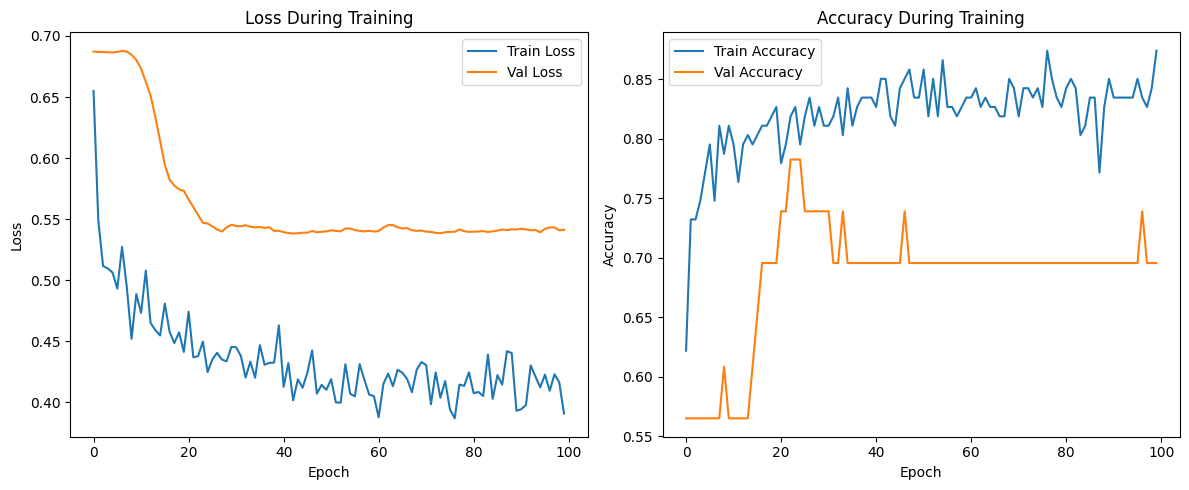

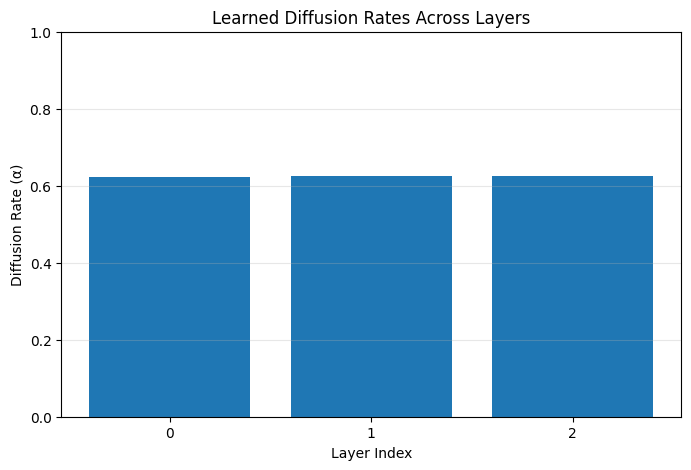

In [5]:
def train_graph_classifier(model, dataloaders, num_epochs=100, learning_rate=0.001, weight_decay=1e-4):
    """
    Train a GNN model for graph classification.
    
    Args:
        model: GNN model
        dataloaders: Dictionary of DataLoader objects
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        weight_decay: Weight decay factor
        
    Returns:
        Trained model and training history
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6
    )
    
    # For tracking best model
    best_val_acc = 0.0
    best_model = None
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for data in dataloaders['train']:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            pred = out.argmax(dim=1)
            train_correct += (pred == data.y).sum().item()
            train_total += data.y.size(0)
            train_loss += loss.item() * data.y.size(0)
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in dataloaders['val']:
                data = data.to(device)
                
                # Forward pass
                out = model(data.x, data.edge_index, data.batch)
                loss = F.cross_entropy(out, data.y)
                
                # Calculate validation accuracy
                pred = out.argmax(dim=1)
                val_correct += (pred == data.y).sum().item()
                val_total += data.y.size(0)
                val_loss += loss.item() * data.y.size(0)
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            print(f"Best Val Acc: {best_val_acc:.4f}")
            print(f"Diffusion rates: {model.get_diffusion_rates()}")
            print("-" * 50)
    
    # Load best model
    model.load_state_dict(best_model)
    
    # Final evaluation on test set
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for data in dataloaders['test']:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            test_correct += (pred == data.y).sum().item()
            test_total += data.y.size(0)
    
    test_acc = test_correct / test_total
    print(f"Test Accuracy: {test_acc:.4f}")
    
    return model, history

# Initialize and train the model
in_features = dataset.num_features
hidden_dim = 64
num_classes = dataset.num_classes

model = GraphClassifier(
    in_features=in_features,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    num_layers=3,
    dropout=0.3
)

trained_model, history = train_graph_classifier(
    model, 
    dataloaders,
    num_epochs=100, 
    learning_rate=0.001,
    weight_decay=5e-4
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the learned diffusion rates
diffusion_rates = trained_model.get_diffusion_rates()
plt.figure(figsize=(8, 5))
plt.bar(range(len(diffusion_rates)), diffusion_rates)
plt.xlabel('Layer Index')
plt.ylabel('Diffusion Rate (α)')
plt.title('Learned Diffusion Rates Across Layers')
plt.ylim(0, 1)
plt.xticks(range(len(diffusion_rates)))
plt.grid(axis='y', alpha=0.3)
plt.show()

## 5. Visualizing Graph-Level Information Diffusion

Let's visualize how information diffuses through molecules and how it contributes to graph-level predictions:

Graph 0 - True label: 1, Predicted label: 1
Prediction confidence: 0.8986


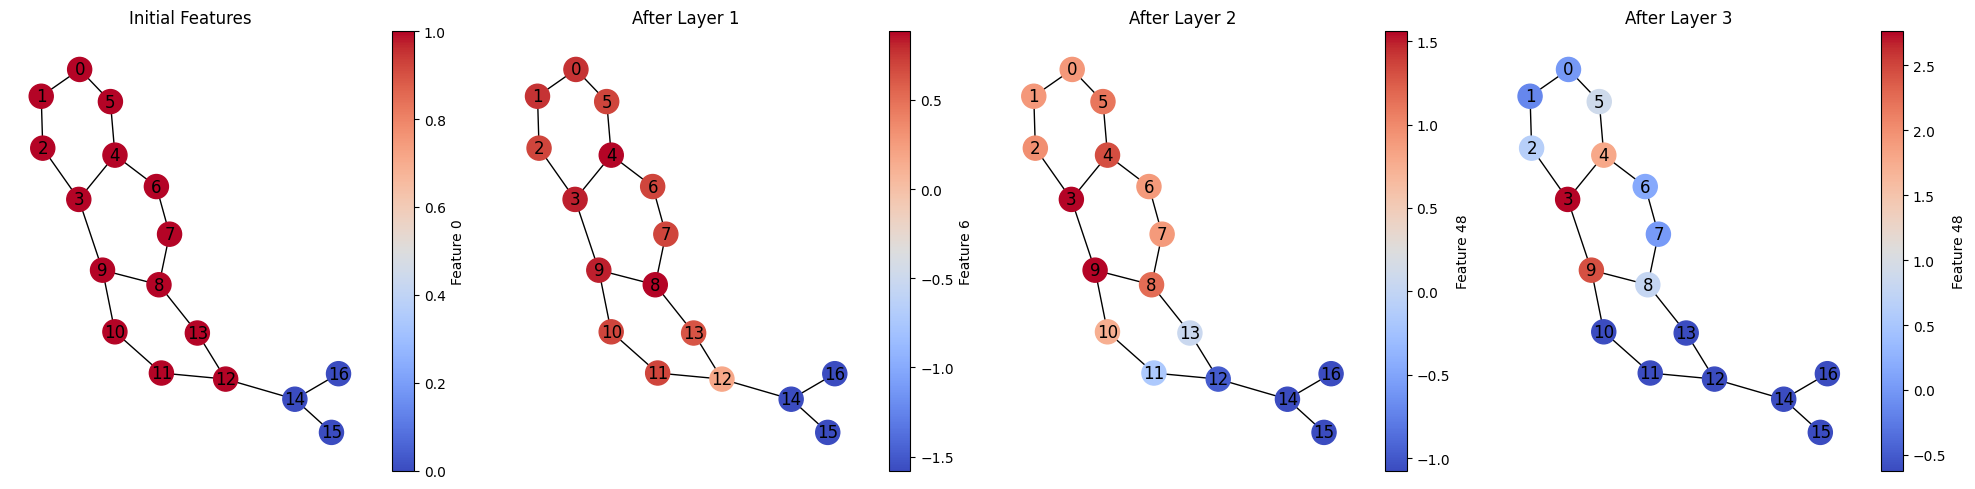

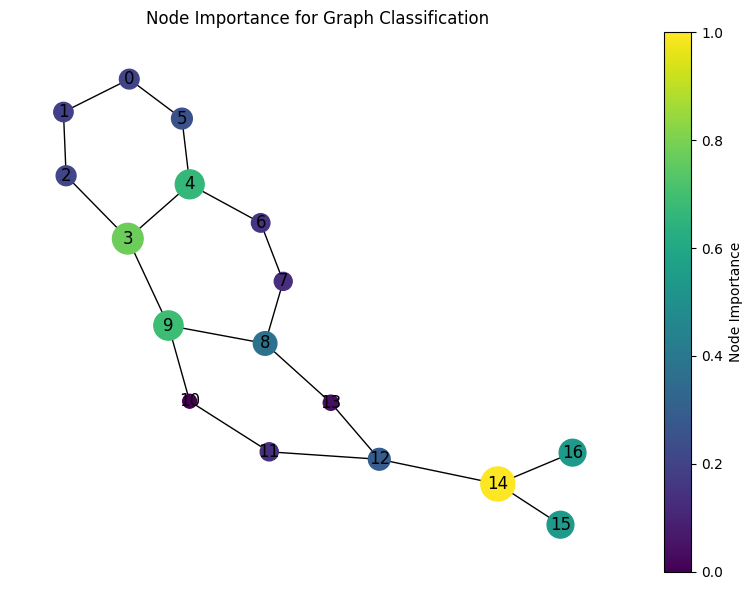

Graph 1 - True label: 0, Predicted label: 1
Prediction confidence: 0.5331


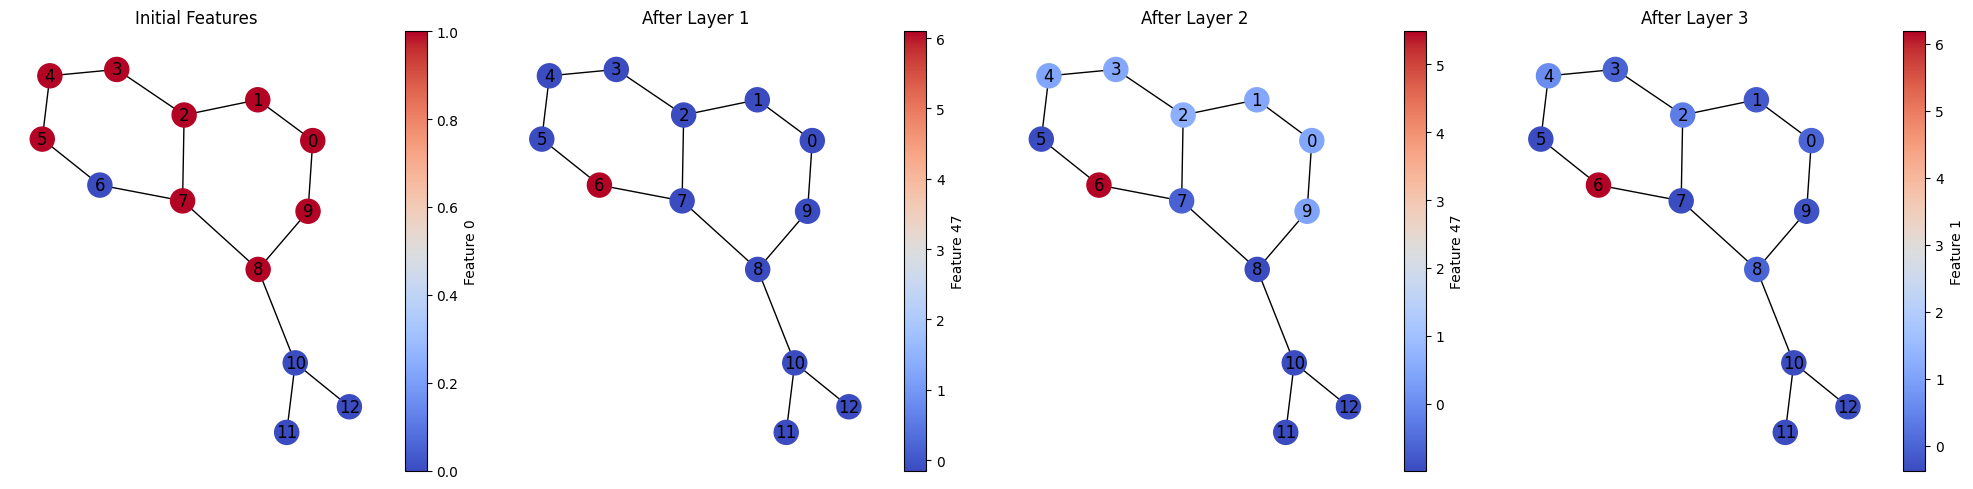

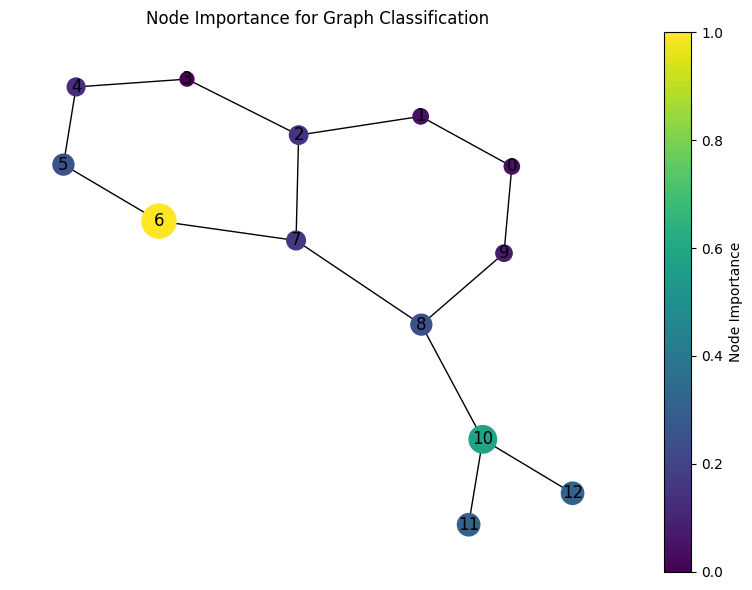

Graph 2 - True label: 0, Predicted label: 0
Prediction confidence: 0.5484


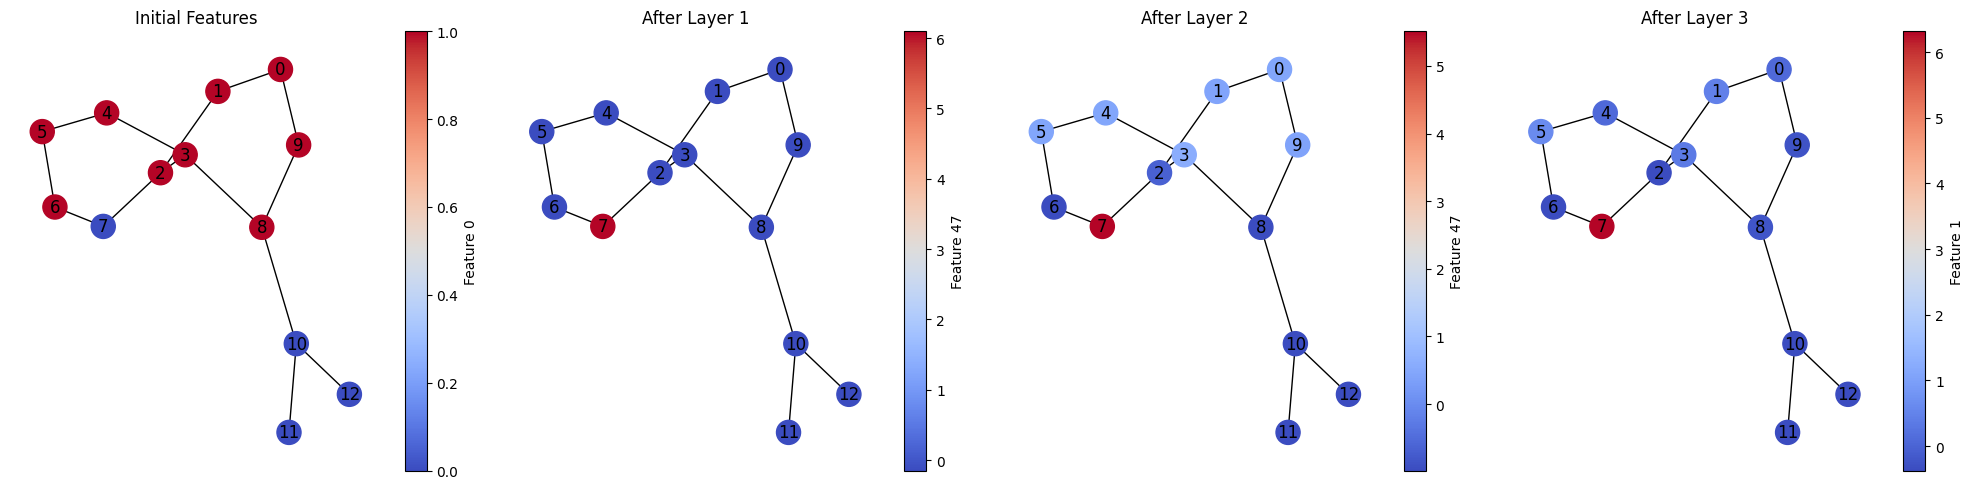

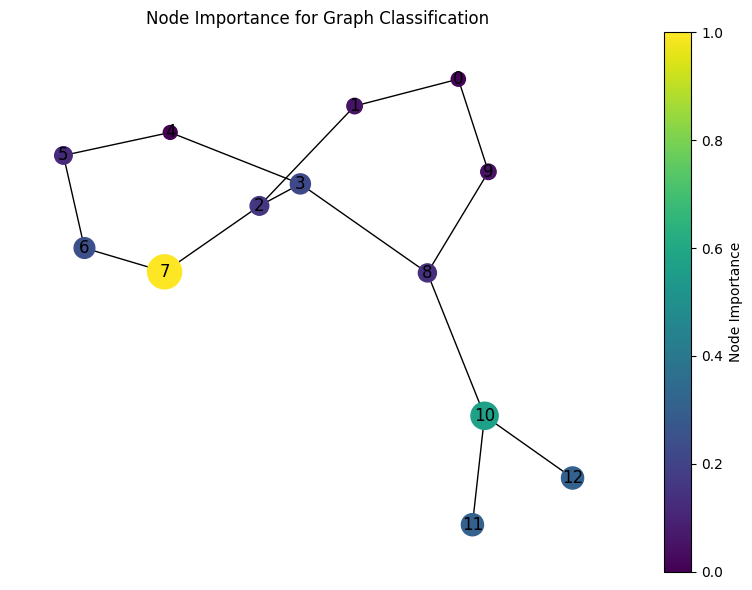

In [7]:
def visualize_graph_diffusion(model, dataset, idx, device):
    """
    Visualize how information diffuses through a specific graph.
    
    Args:
        model: Trained GNN model
        dataset: PyTorch Geometric dataset
        idx: Index of the graph to visualize
        device: PyTorch device
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get the graph data
    data = dataset[idx].to(device)
    
    # Add batch dimension
    batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
    
    # Forward pass with diffusion tracking
    with torch.no_grad():
        out, states = model(data.x, data.edge_index, batch, track_diffusion=True)
    
    # Prediction
    pred = out.argmax(dim=1).item()
    true_label = data.y.item()
    
    print(f"Graph {idx} - True label: {true_label}, Predicted label: {pred}")
    print(f"Prediction confidence: {F.softmax(out, dim=1)[0][pred]:.4f}")
    
    # Convert to NetworkX for visualization
    G = torch_geometric.utils.to_networkx(data, to_undirected=True)
    
    # Number of states to visualize
    num_states = len(states)
    
    # Create a figure with subplots for each state
    fig, axes = plt.subplots(1, num_states, figsize=(5 * num_states, 5))
    
    # Consistent node positions
    pos = nx.spring_layout(G, seed=42)
    
    # Visualize each state
    for i, state in enumerate(states):
        # Move state to CPU and convert to numpy
        node_features = state.cpu().numpy()
        
        # For visualization, use the feature with the highest variance
        feature_vars = np.var(node_features, axis=0)
        feature_idx = np.argmax(feature_vars)
        
        # Normalize feature values for coloring
        feature_values = node_features[:, feature_idx]
        vmin, vmax = feature_values.min(), feature_values.max()
        
        # Draw the graph
        ax = axes[i]
        nx.draw_networkx(
            G, pos=pos, 
            node_color=feature_values,
            cmap='coolwarm',
            vmin=vmin, vmax=vmax,
            node_size=300,
            with_labels=True,
            ax=ax
        )
        
        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label(f'Feature {feature_idx}')
        
        if i == 0:
            ax.set_title(f"Initial Features")
        else:
            ax.set_title(f"After Layer {i}")
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also visualize the attention paid to different nodes during readout
    # For simplicity, we'll use the final layer features as a proxy for attention
    final_features = states[-1].cpu().numpy()
    
    # Compute feature importance as the L2 norm of each node's features
    node_importance = np.linalg.norm(final_features, axis=1)
    
    # Normalize for visualization
    node_importance = (node_importance - node_importance.min()) / (node_importance.max() - node_importance.min() + 1e-8)
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx(
        G, pos=pos,
        node_color=node_importance,
        cmap='viridis',
        node_size=node_importance * 500 + 100,  # Size nodes based on importance
        with_labels=True
    )
    plt.title(f"Node Importance for Graph Classification")
    plt.axis('off')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Node Importance')
    
    plt.tight_layout()
    plt.show()

# Visualize diffusion on a few sample graphs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

for idx in range(3):
    visualize_graph_diffusion(trained_model, dataset, idx, device)

## 6. Analyzing Information Aggregation for Graph-Level Predictions

Let's analyze how the model aggregates node-level information to make graph-level predictions:

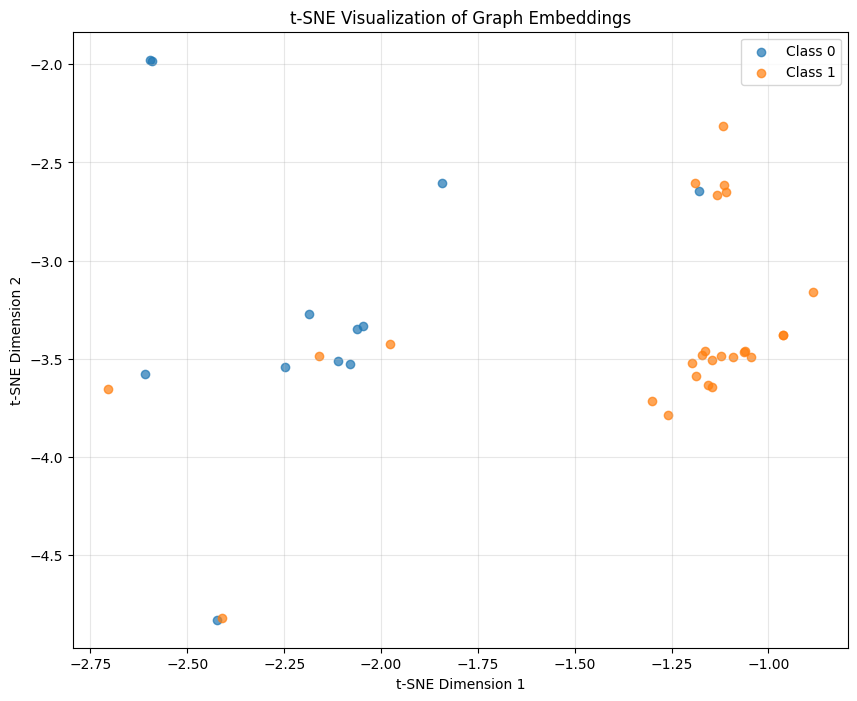

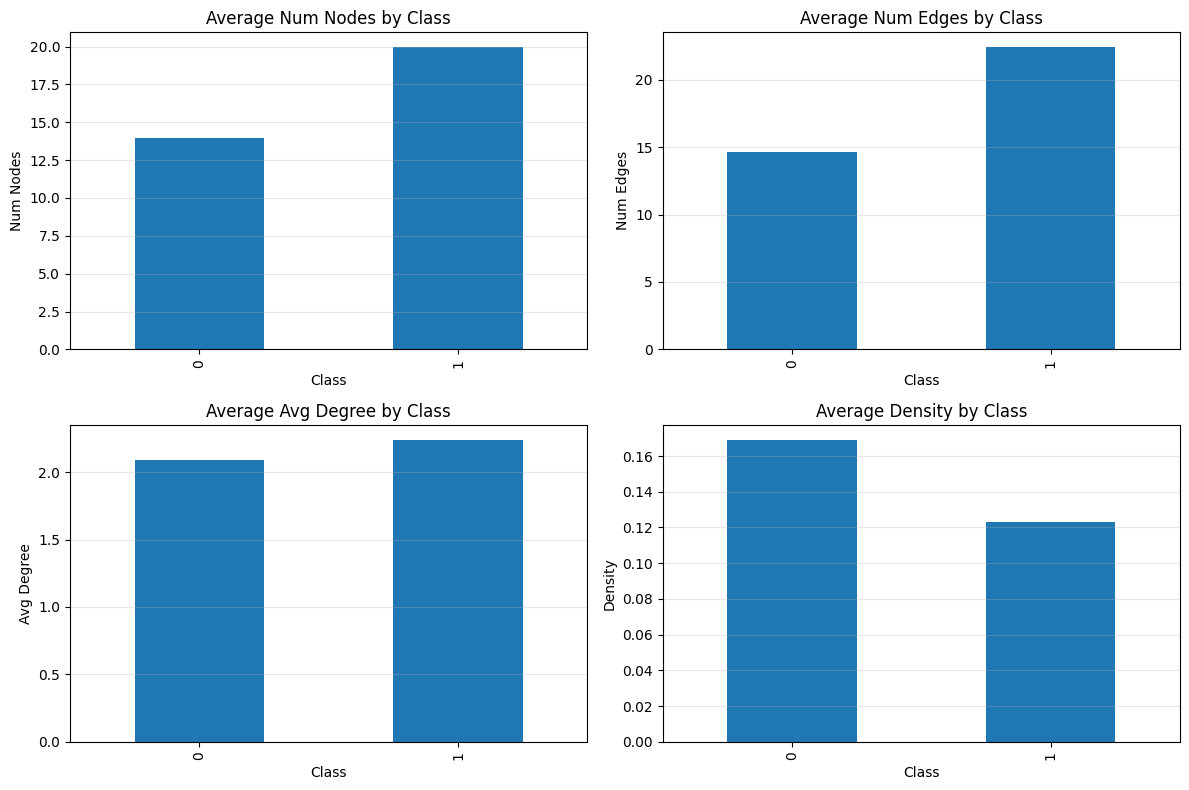

In [8]:
def analyze_graph_embedding(model, dataset, dataloaders, device):
    """
    Analyze how the model aggregates node information into graph embeddings.
    
    Args:
        model: Trained GNN model
        dataset: PyTorch Geometric dataset
        dataloaders: Dictionary of DataLoader objects
        device: PyTorch device
    """
    # Set model to evaluation mode
    model.eval()
    
    # Extract the intermediate representations for all test graphs
    graph_embeddings = []
    graph_labels = []
    
    with torch.no_grad():
        for data in dataloaders['test']:
            data = data.to(device)
            
            # Forward pass through the GNN layers
            h = data.x
            for i in range(model.num_layers):
                h = model.layers[i](h, data.edge_index)
                h = model.batch_norms[i](h)
            
            # Aggregate node features to graph representation
            h_graph_mean = global_mean_pool(h, data.batch)
            h_graph_max = global_max_pool(h, data.batch)
            h_graph = torch.cat([h_graph_mean, h_graph_max], dim=1)
            
            # Store embeddings and labels
            graph_embeddings.append(h_graph.cpu().numpy())
            graph_labels.append(data.y.cpu().numpy())
    
    # Concatenate all embeddings and labels
    graph_embeddings = np.vstack(graph_embeddings)
    graph_labels = np.concatenate(graph_labels)
    
    # Use t-SNE to visualize graph embeddings
    from sklearn.manifold import TSNE
    
    tsne = TSNE(n_components=2, random_state=42)
    graph_embeddings_2d = tsne.fit_transform(graph_embeddings)
    
    # Plot the embeddings
    plt.figure(figsize=(10, 8))
    for label in np.unique(graph_labels):
        idx = graph_labels == label
        plt.scatter(
            graph_embeddings_2d[idx, 0],
            graph_embeddings_2d[idx, 1],
            label=f'Class {label}',
            alpha=0.7
        )
    
    plt.title('t-SNE Visualization of Graph Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Analyze correlation between graph properties and embedding dimensions
    # We'll compute some basic graph properties
    graph_properties = []
    
    for i, data in enumerate(dataset):
        G = torch_geometric.utils.to_networkx(data, to_undirected=True)
        properties = {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
            'density': nx.density(G),
        }
        graph_properties.append(properties)
    
    # Convert to DataFrame
    import pandas as pd
    graph_df = pd.DataFrame(graph_properties)
    
    # Add labels
    graph_df['label'] = [data.y.item() for data in dataset]
    
    # Group by label and compute mean properties
    label_stats = graph_df.groupby('label').mean()
    
    # Plot the average properties by class
    plt.figure(figsize=(12, 8))
    
    for i, property_name in enumerate(['num_nodes', 'num_edges', 'avg_degree', 'density']):
        plt.subplot(2, 2, i+1)
        label_stats[property_name].plot(kind='bar')
        plt.title(f'Average {property_name.replace("_", " ").title()} by Class')
        plt.ylabel(property_name.replace("_", " ").title())
        plt.xlabel('Class')
        plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze graph embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analyze_graph_embedding(trained_model, dataset, dataloaders, device)

## 7. Analyzing Contribution of Different Diffusion Layers

Let's analyze how each diffusion layer contributes to the final prediction:

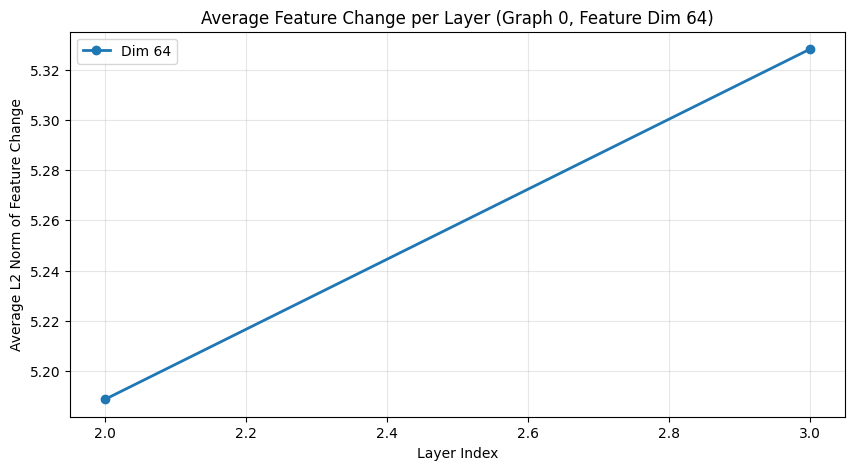

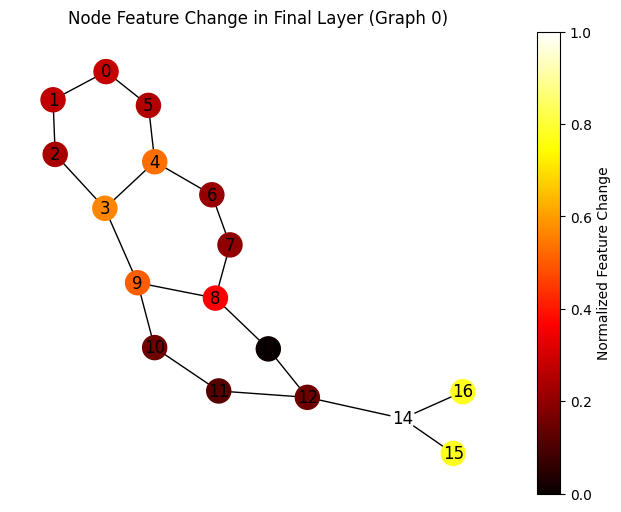

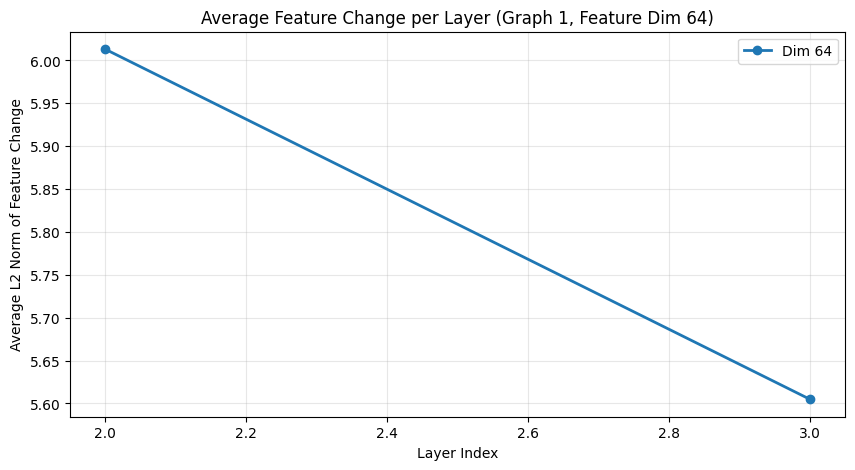

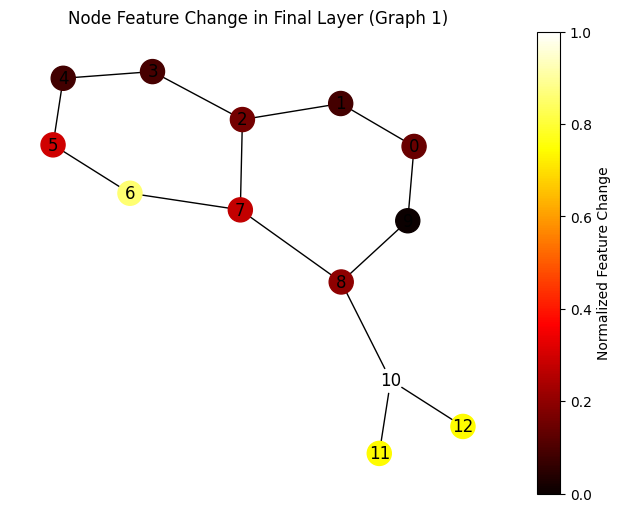

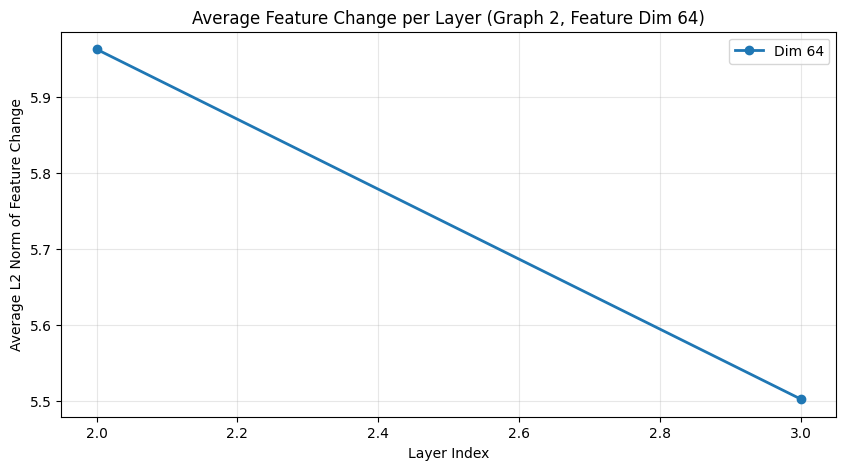

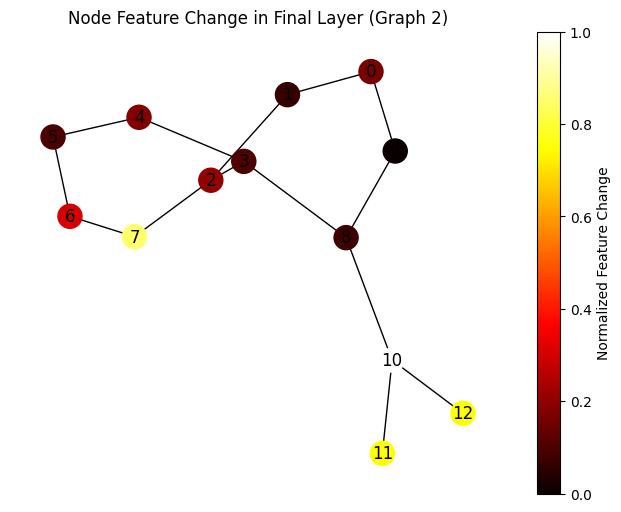

In [11]:
def analyze_layer_contribution(model, dataset, indices, device):
    """
    Analyze how each layer contributes to the final prediction.
    
    Args:
        model: Trained GNN model
        dataset: PyTorch Geometric dataset
        indices: List of graph indices to analyze
        device: PyTorch device
    """
    # Set model to evaluation mode
    model.eval()
    
    for idx in indices:
        # Get the graph data
        data = dataset[idx].to(device)
        
        # Add batch dimension
        batch = torch.zeros(data.x.size(0), dtype=torch.long, device=device)
        
        # Forward pass with diffusion tracking
        with torch.no_grad():
            _, states = model(data.x, data.edge_index, batch, track_diffusion=True)
        
        # Analyze the change in node features at each layer
        changes = []
        
        # Group states by feature dimension
        dimension_groups = {}
        for i, state in enumerate(states):
            dim = state.size(1)
            if dim not in dimension_groups:
                dimension_groups[dim] = []
            dimension_groups[dim].append((i, state))
        
        # Process each dimension group separately
        for dim, state_group in dimension_groups.items():
            group_changes = []
            for i in range(1, len(state_group)):
                prev_idx, prev_state = state_group[i-1]
                curr_idx, curr_state = state_group[i]
                
                # Compute average change per node
                change = torch.norm(curr_state - prev_state, dim=1).mean().item()
                group_changes.append((curr_idx, change))
            
            # Plot the changes for this dimension group
            if group_changes:
                indices, changes_values = zip(*group_changes)
                plt.figure(figsize=(10, 5))
                plt.plot(indices, changes_values, marker='o', linewidth=2, label=f'Dim {dim}')
                plt.title(f'Average Feature Change per Layer (Graph {idx}, Feature Dim {dim})')
                plt.xlabel('Layer Index')
                plt.ylabel('Average L2 Norm of Feature Change')
                plt.grid(alpha=0.3)
                plt.legend()
                plt.show()
        
        # For visualization of the last layer, find states with matching dimensions
        # Find the last two states with the same dimension
        last_dim = states[-1].size(1)
        matching_states = [s for s in states if s.size(1) == last_dim]
        
        if len(matching_states) >= 2:
            last_change = torch.norm(matching_states[-1] - matching_states[-2], dim=1).cpu().numpy()
            
            # Convert to NetworkX for visualization
            G = torch_geometric.utils.to_networkx(data, to_undirected=True)
            
            plt.figure(figsize=(8, 6))
            pos = nx.spring_layout(G, seed=42)
            
            # Normalize for better visualization
            node_change = (last_change - last_change.min()) / (last_change.max() - last_change.min() + 1e-8)
            
            nx.draw_networkx(
                G, pos=pos,
                node_color=node_change,
                cmap='hot',
                node_size=300,
                with_labels=True
            )
            plt.title(f"Node Feature Change in Final Layer (Graph {idx})")
            plt.axis('off')
            
            # Add a colorbar
            sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=plt.gca())
            cbar.set_label('Normalized Feature Change')
            
            plt.show()
        else:
            print(f"Not enough states with matching dimensions for graph {idx} to visualize last layer changes")

# Analyze layer contribution for a few sample graphs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
analyze_layer_contribution(trained_model, dataset, [0, 1, 2], device)

## 8. Conclusion and Insights

In this notebook, we've explored how Graph Neural Networks leverage information diffusion for graph classification tasks. Here are the key takeaways:

1. **Graph-Level Representations**: GNNs create graph-level representations by first diffusing information among nodes and then aggregating these node representations. This two-step process captures both local and global graph structures.

2. **Learned Diffusion Rates**: Our model learned different diffusion rates for each layer, highlighting the importance of controlling how much information flows between neighboring nodes at different stages of the network.

3. **Node Importance**: Not all nodes contribute equally to the final graph classification. Nodes with specific structural properties (like high centrality) often play more important roles in the final prediction.

4. **Layer Contributions**: Different layers in the GNN capture different levels of information. Earlier layers typically capture local patterns, while deeper layers incorporate more global information.

5. **Graph Properties and Classification**: We observed correlations between basic graph properties (like number of nodes, density) and class labels, which the GNN learns to identify through the diffusion process.

The success of GNNs in graph classification tasks demonstrates their ability to effectively capture the structural information in graphs through information diffusion, making them powerful tools for various applications in chemistry, biology, and social network analysis.
